<a href="https://colab.research.google.com/github/sne21star/AI_Project/blob/main/TPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About
This collab file contains my work proccess to trying to write the TPS algorithm. If you want to jump ahead to my implementation it is the last block. This code is also located in the tpsTransformation.py in textsnake.pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Text Retification process
This is the code that must be run to get the TCL of the images. It will visualize the images for you and label it has image_00x.jpg with x being the index of the image in the data set. It will also save a image_00x.jpg_TCL.txt for the TCL lines in a csv format, and also image_00x.txt for the contours of the words in the image

In [ ]:
#Text Center Line Recognition 
#https://github.com/princewang1994/TextSnake.pytorch
#Multi-Processing (spawn https://github.com/pytorch/pytorch/issues/1494)
#$EXPNAME=pretrained
import os
import tensorflow as tf
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["EXPNAME"]="pretrained"
#export CUDA_VISIBLE_DEVICES=1
#export EXPNAME=pretrained
!python /content/drive/My\ Drive/Colab\ Notebooks/TextSnake.pytorch/demo.py $EXPNAME --checkepoch 180 --img_root /content/drive/My\ Drive/Colab\ Notebooks/TextSnake.pytorch/CUTE80/imagesTest
#!python /content/drive/My\ Drive/Colab\ Notebooks/see/chainer/text_recognition_demo.py /content/drive/My\ Drive/Colab\ Notebooks/see/modelText/text_recognition_model/model /content/drive/My\ Drive/Colab\ Notebooks/see/modelText/text_recognition_model/model/model_190000.npz /content/drive/My\ Drive/Colab\ Notebooks/TextSnake.pytorch/finalImages/tps.jpg /content/drive/My\ Drive/Colab\ Notebooks/see/datasets/textrec/ctc_char_map.json

# TPS 
This is what the TPS proccess will look like. 

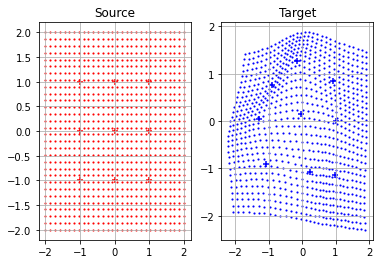

In [ ]:
import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, squareform

#This is not my code. This was just to test how TPS look like. 

#https://gist.github.com/bgshih/e252ba7148590a381f9c

#https://github.com/ISS-Kerui/warp-image-TPS/blob/master/TPSwarping.py (TPS IN CV Library)

#https://github.com/WarBean/tps_stn_pytorch

#https://github.com/iwyoo/tf_ThinPlateSpline

def makeT(cp):
    # cp: [K x 2] control points
    # T: [(K+3) x (K+3)]
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    # p: [N x 2], input points
    # cp: [K x 2], control points
    # pLift: [N x (3+K)], lifted input points
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift

# source control points
x, y = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)
x, y = np.meshgrid(x, y)
xs = x.flatten()
ys = y.flatten()
cps = np.vstack([xs, ys]).T

# target control points
xt = xs + np.random.uniform(-0.3, 0.3, size=xs.size)
yt = ys + np.random.uniform(-0.3, 0.3, size=ys.size)

# construct T
T = makeT(cps)

# solve cx, cy (coefficients for x and y)
xtAug = np.concatenate([xt, np.zeros(3)])
ytAug = np.concatenate([yt, np.zeros(3)])
cx = nl.solve(T, xtAug) # [K+3]
cy = nl.solve(T, ytAug)

# dense grid
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
x, y = np.meshgrid(x, y)
xgs, ygs = x.flatten(), y.flatten()
gps = np.vstack([xgs, ygs]).T

# transform
pgLift = liftPts(gps, cps) # [N x (K+3)]
xgt = np.dot(pgLift, cx.T)
ygt = np.dot(pgLift, cy.T)

# display
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.subplot(1, 2, 1)
plt.title('Source')
plt.grid()
plt.scatter(xs, ys, marker='+', c='r', s=40)
plt.scatter(xgs, ygs, marker='.', c='r', s=5)
plt.subplot(1, 2, 2)
plt.title('Target')
plt.grid()
plt.scatter(xt, yt, marker='+', c='b', s=40)
plt.scatter(xgt, ygt, marker='.', c='b', s=5)
plt.show()


# OpenCV does not work 
When trying to implement the TPS library it did not work

[[[ 767.  639.]
  [ 793.  618.]
  [ 818.  597.]
  [ 847.  580.]
  [ 881.  559.]
  [ 919.  540.]
  [ 970.  525.]
  [1020.  515.]
  [1080.  515.]
  [1134.  521.]
  [1189.  532.]
  [1206.  540.]
  [1215.  546.]
  [1219.  548.]
  [1223.  553.]
  [1261.  567.]
  [1295.  582.]
  [1324.  603.]
  [1337.  612.]
  [1345.  618.]
  [1345.  622.]
  [1345.  622.]]]


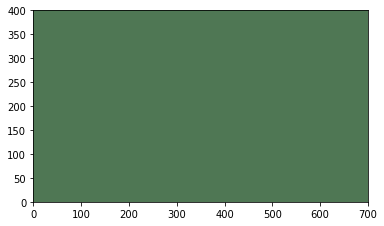

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

tps = cv2.createThinPlateSplineShapeTransformer()

sshape = [[767, 639],
[793, 618],
[818, 597],
[847, 580],
[881, 559],
[919, 540],
[970, 525],
[1020, 515],
[1080, 515],
[1134, 521],
[1189, 532],
[1206, 540],
[1215, 546],
[1219, 548],
[1223, 553],
[1261, 567],
[1295, 582],
[1324, 603],
[1337, 612],
[1345, 618],
[1345, 622],
[1345, 622]]
tshape = sshape

sshape = np.array(sshape,np.float32)
tshape = np.array(sshape,np.float32)

sshape = sshape.reshape(1,-1,2)
tshape = tshape.reshape(1,-1,2)
print(sshape)
matches = list()
index = 0
for x in sshape[0] :
  matches.append(cv2.DMatch(index,index,0))
  index += 1
tps.estimateTransformation(tshape,sshape,matches)
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/CUTE80/images/image061.jpg', 1)
out_img = tps.warpImage(img)

fig, ax = plt.subplots()
ax.set_xlim([0,700])
ax.set_ylim([0,400])
plt.imshow(out_img)
#plt.savefig("warped")

#https://stackoverflow.com/questions/42426397/results-from-my-thin-plate-spline-interpolation-implementation-are-dependant-of

# TPS implementation 
I tried recreating the TPS class. I looked at this article to model the algorithm (https://www.researchgate.net/publication/2364266_Approximate_Thin_Plate_Spline_Mappings) as mentioned in my final paper. 

3
[[-0.         -0.18230892  0.15799158]
 [-0.18230892 -0.         -0.18230892]
 [ 0.15799158 -0.18230892 -0.        ]]
[[1.  0.  0. ]
 [1.  0.4 0.4]
 [1.  0.8 0.8]]
[[1.  1.  1. ]
 [0.  0.4 0.8]
 [0.  0.4 0.8]]
[[-0.         -0.18230891  0.15799159  1.          0.          0.        ]
 [-0.18230891 -0.         -0.18230891  1.          0.4         0.4       ]
 [ 0.15799159 -0.18230891 -0.          1.          0.8         0.8       ]
 [ 1.          1.          1.          0.          0.          0.        ]
 [ 0.          0.4         0.8         0.          0.          0.        ]
 [ 0.          0.4         0.8         0.          0.          0.        ]]
3
[[-0.         -0.18230892  0.15799158]
 [-0.18230892 -0.         -0.18230892]
 [ 0.15799158 -0.18230892 -0.        ]]
[[1.  0.  0. ]
 [1.  0.4 0.4]
 [1.  0.8 0.8]]
[[1.  1.  1. ]
 [0.  0.4 0.8]
 [0.  0.4 0.8]]
[[-0.         -0.18230891  0.15799159  1.          0.          0.        ]
 [-0.18230891 -0.         -0.18230891  1.         

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


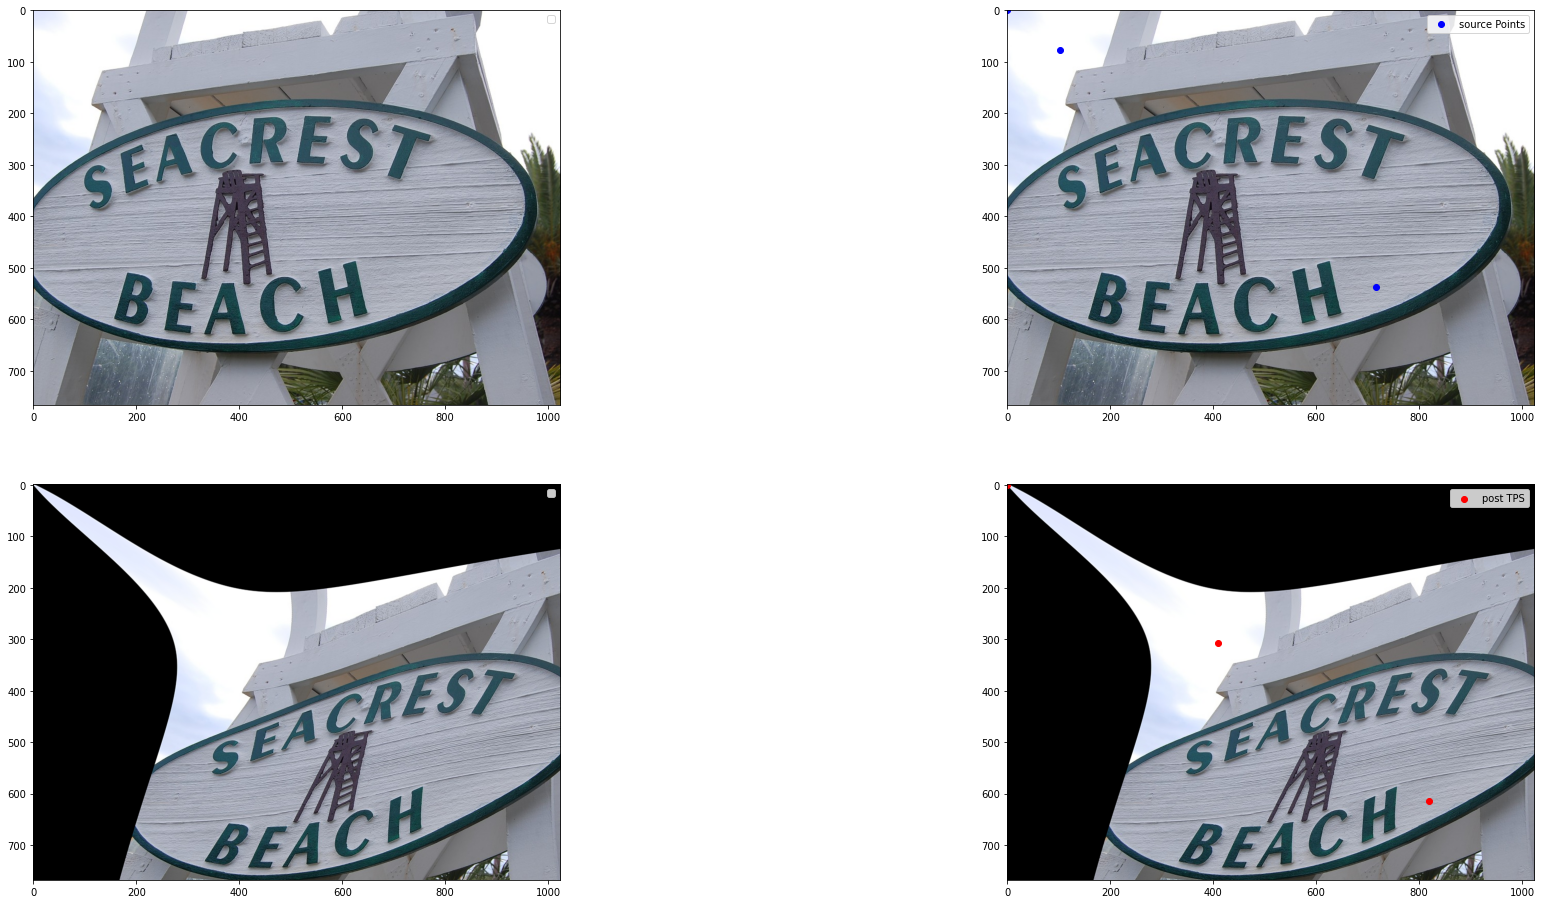

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
'''
Followed formulas given in this paper: 
https://www.researchgate.net/publication/2364266_Approximate_Thin_Plate_Spline_Mappings
'''
def warpImage(pointsS, pointsT, originalImg, dimensions):
    t_Final = getPointsT(pointsS, pointsT) #get theta from source points and target points
    warppedGrid = warpGrid(t_Final, pointsT, dimensions)
    rescale_XCoord = (warppedGrid[:, :, 0] * dimensions[1])
    rescale_XCoord = rescale_XCoord.astype(np.float32)
    rescale_YCoord = (warppedGrid[:, :, 1] * dimensions[0])
    rescale_YCoord = rescale_YCoord.astype(np.float32)
    warppedImage = cv2.remap(originalImg, rescale_XCoord, rescale_YCoord, cv2.INTER_CUBIC)
    return warppedImage

def plotwarppedImage(img, warpImg, pointsS, pointsT, path):
    #cv2.imwrite(path, warped)
    fig, axis = plt.subplots(2, 2, figsize=(32,16))
    axis[0][0].imshow(img[...,::-1], origin='upper', label='original')
    axis[0][1].imshow(img[...,::-1], origin='upper')
    Xdata = pointsS[:, 0]*img.shape[1]
    YData = pointsS[:, 1]*img.shape[0]
    axis[0][1].scatter(Xdata, YData, color='blue', label='source Points')
    axis[1][0].imshow(warpImg[...,::-1], origin='upper')
    axis[1][1].imshow(warpImg[...,::-1], origin='upper')
    Xdata = pointsT[:, 0]*warped.shape[1]
    YData = pointsT[:, 1]*warpImg.shape[0]
    axis[1][1].scatter(Xdata,YData,color='red', label='post TPS')
    axis[0][0].legend()
    axis[0][1].legend()
    axis[1][0].legend()
    axis[1][1].legend()
    plt.show()
class thinPSTransformation:
    '''
    L2NORM 
    '''
    @staticmethod
    def L2NORM(xyi, xy):
        topLeftMatrix = xyi[:, None, :2]
        bottomLeftMatrix = xy[None, :, :2]
        squareV = np.square(topLeftMatrix - bottomLeftMatrix ).sum(-1)
        sqrtV = np.sqrt(squareV)
        return sqrtV
    '''
    Bending energy equation  
    '''
    @staticmethod
    def U(rij):
        equationResult = pow(rij,2) * np.log(rij+1e-6)
        return equationResult

    @staticmethod
    def calcTheta(point_Coord):        
        width = point_Coord.shape[0]
        print(width)
        K = thinPSTransformation.U(thinPSTransformation.L2NORM(point_Coord, point_Coord))
        P = np.ones((width, 3), dtype=np.float32)
        P[:, 1:] = point_Coord[:, :2]
        P_T = P.T
        O = np.zeros((width+3, width+3), dtype=np.float32)
        o = np.zeros(width+3, dtype=np.float32)
        o[:width] = point_Coord[:, -1]
        O[:width, :width] = K
        O[:width, -3:] = P
        O[-3:, :width] = P_T
        print(K)
        print(P)
        print(P_T)
        print(O)
        t_Final = np.linalg.lstsq(O,o)[0] # Least sqaures regression 
        return t_Final

    @staticmethod
    def interpoltantEquation(listCoord, t):
        x = listCoord[0]
        y = listCoord[1]
        x = np.atleast_2d(x)
        eucledianDistance = thinPSTransformation.L2NORM(x, y)
        K = thinPSTransformation.U(eucledianDistance)
        wVector =  t[:-3]
        aVector = t[-3:]
        sumValue = np.dot(K, wVector)
        return aVector[0] + aVector[1]*x[:, 0] + aVector[2]*x[:, 1] +sumValue


def gridNorm(gridShape):
    height,width = gridShape[:2]    
    L_1 = np.empty((height, width, 2))
    L_1[..., 0] = np.linspace(0, 1, width)
    L_1[..., 1] = np.expand_dims(np.linspace(0, 1, height, dtype=np.float32), -1)
    return L_1
    
def getPointsT(pointsS, pointsT):
    change = pointsS - pointsT
    points_X = np.column_stack((pointsT, change[:, 0]))
    points_Y = np.column_stack((pointsT, change[:, 1]))
    T_X = thinPSTransformation.calcTheta(points_X)
    T_Y = thinPSTransformation.calcTheta(points_Y)
    return np.stack((T_X, T_Y), -1)


def warpGrid(t, pointsT, dimensions):    
    gridNormalized = gridNorm(dimensions)
    xNorm = gridNormalized.reshape((-1, 2))
    yNorm = gridNormalized.reshape((-1, 2))
    dx = thinPSTransformation.interpoltantEquation([xNorm, pointsT], t[:, 0])
    dx = dx.reshape(dimensions[:2])
    dy = thinPSTransformation.interpoltantEquation([yNorm, pointsT], t[:, 1])
    dy = dy.reshape(dimensions[:2])
    gridWarpped = np.stack((dx, dy), -1)
    gridWarpped = gridWarpped + gridNormalized
    return gridWarpped

img = cv2.imread('/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/CUTE80/image002.jpg')
pointsS = np.array([[0.0, 0.0],[0.1, 0.1],[0.7, 0.7]])

pointsT = np.array([[0.0, 0.0], [0.4, 0.4],[0.8, 0.8]])
dimensions = img.shape
warped = warpImage(pointsS, pointsT, img, dimensions)
plotwarppedImage(img, warped, pointsS, pointsT, path=None)

# Final Code
This code section looks at one image at a time but can easily be changed to look at multiple images at a time. 

/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/CUTE80/image002.jpg
/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/output/image002.jpg_TCL.txt
WIDTH
1024
HEIGHT
768
18
[[-0.00000000e+00 -2.37953673e-05 -8.46087872e-05 -1.76452160e-04
  -8.02325155e-04 -3.38447647e-03 -1.13900066e-02 -2.28850470e-02
  -3.79912904e-02 -5.54226456e-02 -7.53404880e-02 -9.78003094e-02
  -1.20764412e-01 -1.41400093e-01 -1.59882599e-01 -1.74028421e-01
  -1.82048249e-01 -1.83595269e-01]
 [-2.37953673e-05 -0.00000000e+00 -2.37953673e-05 -8.46087872e-05
  -6.10631080e-04 -3.03002955e-03 -1.08303622e-02 -2.21852434e-02
  -3.71937871e-02 -5.45695955e-02 -7.44688928e-02 -9.69501476e-02
  -1.19978443e-01 -1.40713980e-01 -1.59337262e-01 -1.73660451e-01
  -1.81879133e-01 -1.83519897e-01]
 [-8.46087872e-05 -2.37953673e-05 -0.00000000e+00 -2.37953673e-05
  -4.41435272e-04 -2.69107522e-03 -1.02804275e-02 -2.14917442e-02
  -3.64000211e-02 -5.37182810e-02 -7.35973138e-02 -9.60984346e-02
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


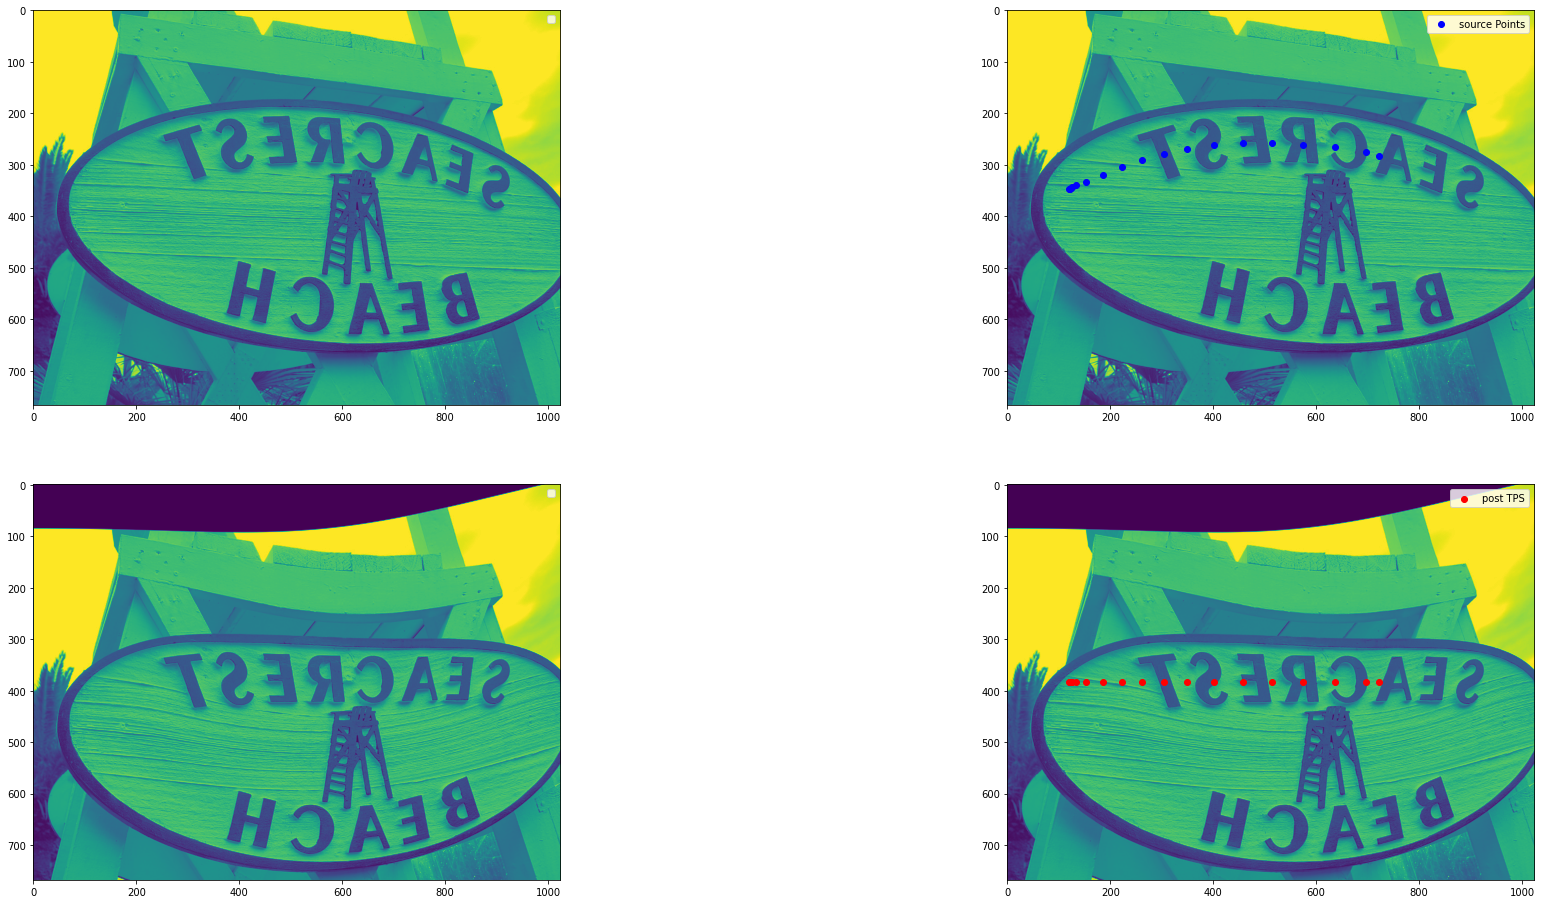

[[120.0, 384.0], [122.0, 384.0], [124.0, 384.0], [126.0, 384.0], [134.0, 384.0], [152.0, 384.0], [186.0, 384.0], [222.0, 384.0], [262.0, 384.0], [304.0, 384.0], [350.0, 384.0], [402.0, 384.0], [458.0, 384.0], [514.0, 384.0], [574.0, 384.0], [636.0, 384.0], [696.0, 384.0], [722.0, 384.0]]
18
[[-0.00000000e+00 -2.37953673e-05 -8.46087872e-05 -1.76452160e-04
  -8.02325155e-04 -3.38447647e-03 -1.13900066e-02 -2.28850470e-02
  -3.79912904e-02 -5.54226456e-02 -7.53404880e-02 -9.78003094e-02
  -1.20764412e-01 -1.41400093e-01 -1.59882599e-01 -1.74028421e-01
  -1.82048249e-01 -1.83595269e-01]
 [-2.37953673e-05 -0.00000000e+00 -2.37953673e-05 -8.46087872e-05
  -6.10631080e-04 -3.03002955e-03 -1.08303622e-02 -2.21852434e-02
  -3.71937871e-02 -5.45695955e-02 -7.44688928e-02 -9.69501476e-02
  -1.19978443e-01 -1.40713980e-01 -1.59337262e-01 -1.73660451e-01
  -1.81879133e-01 -1.83519897e-01]
 [-8.46087872e-05 -2.37953673e-05 -0.00000000e+00 -2.37953673e-05
  -4.41435272e-04 -2.69107522e-03 -1.0280427

No handles with labels found to put in legend.
No handles with labels found to put in legend.


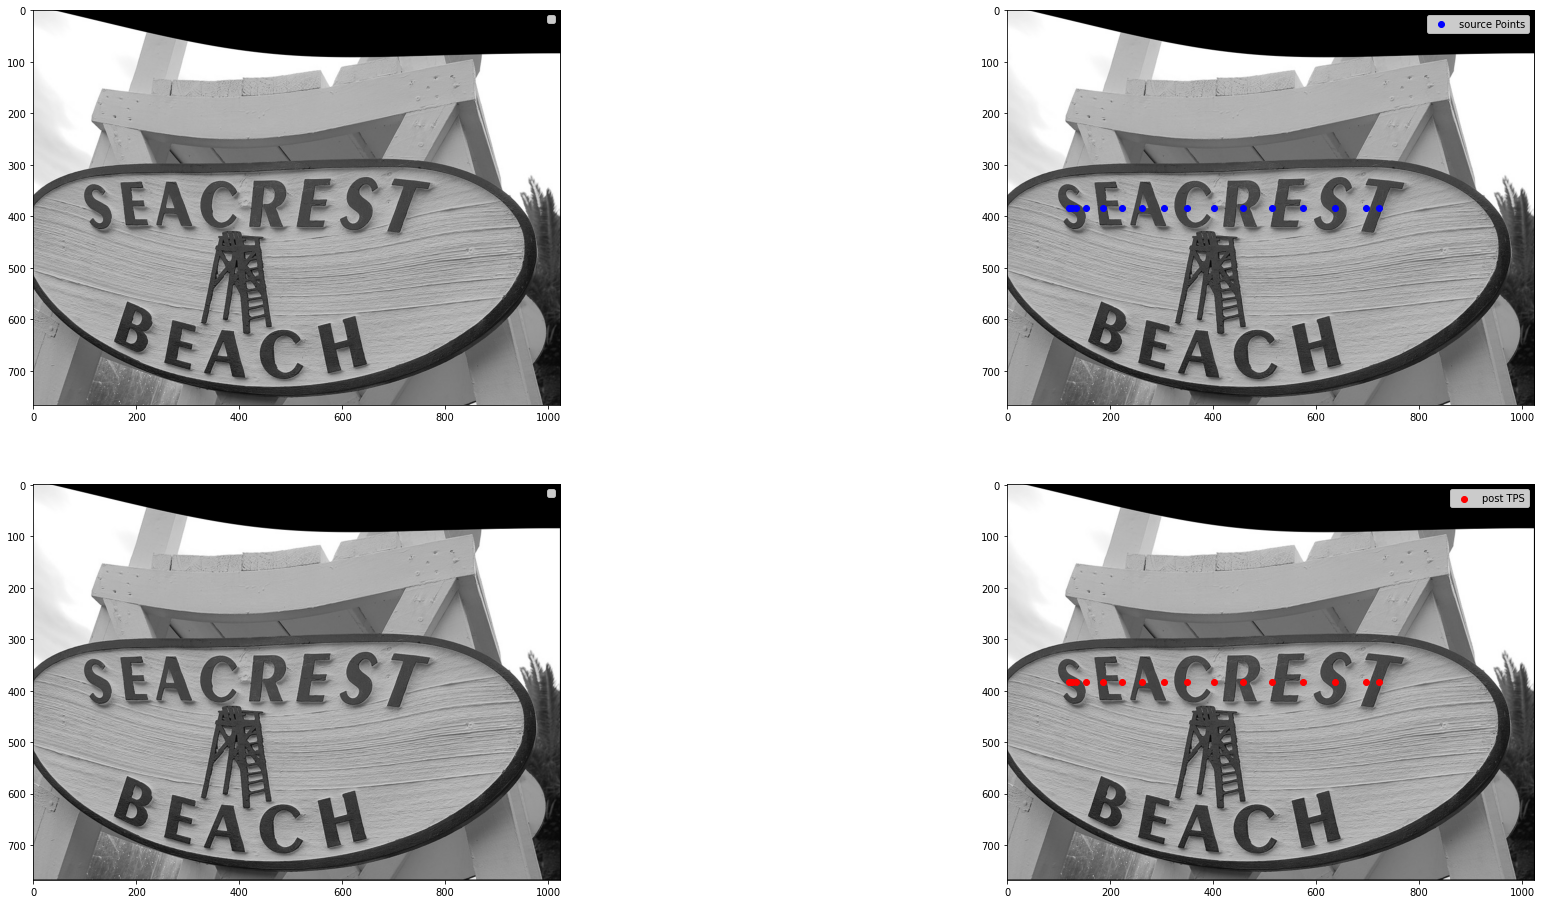

(70.0, 307.2, 772.0, 460.8)


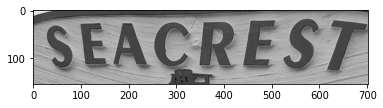

In [ ]:
import csv
import cv2
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2gray

contoursList = []

def getContours():
  with open('/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/output/image001.txt', 'r') as fd:
    reader = csv.reader(fd)
    listElement = []
    for row in reader:
      listElement.append(row)
    
    index = 0 
    temp = []
    contours = []
    for l in listElement[0]:
      if (index):
        x = int(l)
        temp.append(x)
        index = 0
        contours.append(temp)
        temp = []
      else:
        x = int(l)
        temp.append(x)
        index += 1 
    return contours 
def getFiles(pathToTCL):
  with open(pathToTCL, 'r') as fd:
      reader = csv.reader(fd)
      listElement = []
      for row in reader:
        temp = []
        #print(row)
        temp.append(int(row[0]))
        temp.append(int(row[1]))
        listElement.append(temp)
        #print(temp)
  return listElement


class thinPSTransformation:
    '''
    L2NORM 
    '''
    @staticmethod
    def L2NORM(xyi, xy):
        topLeftMatrix = xyi[:, None, :2]
        bottomLeftMatrix = xy[None, :, :2]
        squareV = np.square(topLeftMatrix - bottomLeftMatrix ).sum(-1)
        sqrtV = np.sqrt(squareV)
        return sqrtV
    '''
    Bending energy equation  
    '''
    @staticmethod
    def U(rij):
        equationResult = pow(rij,2) * np.log(rij+1e-6)
        return equationResult

    @staticmethod
    def calcTheta(point_Coord):        
        width = point_Coord.shape[0]
        print(width)
        K = thinPSTransformation.U(thinPSTransformation.L2NORM(point_Coord, point_Coord))
        P = np.ones((width, 3), dtype=np.float32)
        P[:, 1:] = point_Coord[:, :2]
        P_T = P.T
        O = np.zeros((width+3, width+3), dtype=np.float32)
        o = np.zeros(width+3, dtype=np.float32)
        o[:width] = point_Coord[:, -1]
        O[:width, :width] = K
        O[:width, -3:] = P
        O[-3:, :width] = P_T
        print(K)
        print(P)
        print(P_T)
        print(O)
        t_Final = np.linalg.lstsq(O,o)[0] # Least sqaures regression 
        return t_Final

    @staticmethod
    def interpoltantEquation(listCoord, t):
        x = listCoord[0]
        y = listCoord[1]
        x = np.atleast_2d(x)
        eucledianDistance = thinPSTransformation.L2NORM(x, y)
        K = thinPSTransformation.U(eucledianDistance)
        wVector =  t[:-3]
        aVector = t[-3:]
        sumValue = np.dot(K, wVector)
        return aVector[0] + aVector[1]*x[:, 0] + aVector[2]*x[:, 1] +sumValue


def gridNorm(gridShape):
    height,width = gridShape[:2]    
    L_1 = np.empty((height, width, 2))
    L_1[..., 0] = np.linspace(0, 1, width)
    L_1[..., 1] = np.expand_dims(np.linspace(0, 1, height, dtype=np.float32), -1)
    return L_1
    
def getPointsT(pointsS, pointsT):
    change = pointsS - pointsT
    points_X = np.column_stack((pointsT, change[:, 0]))
    points_Y = np.column_stack((pointsT, change[:, 1]))
    T_X = thinPSTransformation.calcTheta(points_X)
    T_Y = thinPSTransformation.calcTheta(points_Y)
    return np.stack((T_X, T_Y), -1)


def warpGrid(t, pointsT, dimensions):    
    gridNormalized = gridNorm(dimensions)
    xNorm = gridNormalized.reshape((-1, 2))
    yNorm = gridNormalized.reshape((-1, 2))
    dx = thinPSTransformation.interpoltantEquation([xNorm, pointsT], t[:, 0])
    dx = dx.reshape(dimensions[:2])
    dy = thinPSTransformation.interpoltantEquation([yNorm, pointsT], t[:, 1])
    dy = dy.reshape(dimensions[:2])
    gridWarpped = np.stack((dx, dy), -1)
    gridWarpped = gridWarpped + gridNormalized
    return gridWarpped


def coordDictionary(matrixContours):
  yCoord = []
  for row in matrixContours:
      yCoord.append(row[1])
  return min(yCoord), max(yCoord)

def topBottomSpline(matrixContours, value, height):
  returnList = []
  for row in matrixContours:
      temp = []
      temp.append(row[0])
      temp.append(height/2)
      #temp.append(abs(value))
      returnList.append(temp)
  return returnList

def straighten(matrixContours):
  returnList = []
  index = 25
  for row in matrixContours:
      temp = []
      temp.append(row[0]  + index * 5)
      temp.append(row[1])
      returnList.append(temp)
      index -= 1
  return returnList


def createDictionary(matrixContours):
  xCoor = []
  yCoor = []
  output = {} 
  for row in matrixContours:
      if(row[0] not in output):
        output[row[0]] = []
        output[row[0]].append(row[1])
      else:
        output[row[0]].append(row[1])
  return output

def splitP(outputDict):
  returnList = []
  for x in outputDict:
    if(len(outputDict[x]) == 1):
      temp = []
      temp.append(x)
      temp.append(outputDict[x][0])
      returnList.append(temp)
  return returnList

def combineXY(xList,yList):
  returnList = []
  for x,y in zip(xList,yList):
      temp = []
      temp.append(x)
      temp.append(y)
      returnList.append(temp)
  return returnList

def minMax(listInput):
  xCoor = []
  for x in listInput:
      temp = []
      xCoor.append(x[0])
  return min(xCoor), max(xCoor)

def warpImage(pointsS, pointsT, originalImg, dimensions):
    t_Final = getPointsT(pointsS, pointsT) #get theta from source points and target points
    warppedGrid = warpGrid(t_Final, pointsT, dimensions)
    rescale_XCoord = (warppedGrid[:, :, 0] * dimensions[1])
    rescale_XCoord = rescale_XCoord.astype(np.float32)
    rescale_YCoord = (warppedGrid[:, :, 1] * dimensions[0])
    rescale_YCoord = rescale_YCoord.astype(np.float32)
    warppedImage = cv2.remap(originalImg, rescale_XCoord, rescale_YCoord, cv2.INTER_CUBIC)
    return warppedImage

def plotwarppedImage(img, warpImg, pointsS, pointsT, path):
    cv2.imwrite(path, warpImg)
    fig, axis = plt.subplots(2, 2, figsize=(32,16))
    axis[0][0].imshow(img[...,::-1], origin='upper', label='original')
    axis[0][1].imshow(img[...,::-1], origin='upper')
    Xdata = pointsS[:, 0]*img.shape[1]
    YData = pointsS[:, 1]*img.shape[0]
    axis[0][1].scatter(Xdata, YData, color='blue', label='source Points')
    axis[1][0].imshow(warpImg[...,::-1], origin='upper')
    axis[1][1].imshow(warpImg[...,::-1], origin='upper')
    Xdata = pointsT[:, 0]*warpImg.shape[1]
    YData = pointsT[:, 1]*warpImg.shape[0]
    axis[1][1].scatter(Xdata,YData,color='red', label='post TPS')
    axis[0][0].legend()
    axis[0][1].legend()
    axis[1][0].legend()
    axis[1][1].legend()
    plt.show()

def tpsTransformation(img, filename, pathToTCL):
  ims = Image.open(filename) 
  w,h = ims.size
  tcl_LinesX = getFiles(pathToTCL)
  sshape =  tcl_LinesX
  #print(sshape)
  print("WIDTH")
  print(w)
  print("HEIGHT")
  print(h)
  contours = getContours()
  minY, maxY = coordDictionary(contours)
  
  tshapeTop = topBottomSpline(sshape, maxY-h/2, h)
  tshapeBottom = topBottomSpline(sshape, minY+h/2, h)

  #tshapeTop[len(tshapeTop)-1][1] = tshapeTop[len(tshapeTop)-1][1] 
  #tshapeBottom[len(tshapeBottom)-1][1] = tshapeBottom[len(tshapeBottom)-1][1] - 1

  #Bottom p2 
  index = 0 
  listTemp = []
  for x in sshape:
    temp = []
    temp.append(x[0]/w)
    temp.append(x[1]/h)
    listTemp.append(temp)
    if (index == 30):
      break
    else:
      index += 1
  sshape = listTemp
  #print(sshape)
  listTemp = []
  index = 0
  for x in tshapeBottom:
    temp = []
    temp.append(x[0]/w)
    temp.append(x[1]/h)
    listTemp.append(temp)
    if (index == 30):
      break 
    else:
      index += 1
  tshapeBottom = listTemp

  #print(tshapeBottom)
  #print("LENGTH")
  #print(len(sshape))
  #print(len(tshapeBottom))

  pointsS = np.array(sshape)

  pointsT = np.array(tshapeBottom)
  warped = warpImage(pointsS, pointsT, img, (h,w))
  xList = pointsT[:, 0]*warped.shape[1]
  yList = pointsT[:, 1]*warped.shape[0]
  cdst = combineXY(xList,yList)
  
  plotwarppedImage(img, warped,pointsS, pointsT, '/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/intermediate/final.jpg')

  img = cv2.imread('/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/intermediate/final.jpg', 1)
  ims = Image.open('/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/intermediate/final.jpg') 
  w,h = ims.size

  tcl_LinesX = getFiles(pathToTCL)
  sshape =  cdst
  #print(sshape)
  minY, maxY = coordDictionary(contours)
  tshapeTop = topBottomSpline(sshape, maxY-h/2, h)
  tshapeBottom = topBottomSpline(sshape, minY+h/2, h)
  #tshapeTop[len(tshapeTop)-1][1] = tshapeTop[len(tshapeTop)-1][1] - 1
  #tshapeBottom[len(tshapeBottom)-1][1] = tshapeBottom[len(tshapeBottom)-1][1] - 1

  #print(tshapeTop)
  #print(tshapeBottom)

  #Top p2 
  index = 0 
  listTemp = []
  for x in sshape:
    temp = []
    temp.append(x[0]/w)
    temp.append(x[1]/h)
    listTemp.append(temp)
    if (index == 30):
      break
    else:
      index += 1
  sshape = listTemp
  #print(sshape)
  listTemp = []
  index = 0
  print(tshapeTop)

  minX, maxX = minMax(tshapeTop)
  Yvalue = tshapeTop[0][1]
  
  for x in tshapeTop:
    temp = []
    temp.append(x[0]/w)
    temp.append(x[1]/h)
    listTemp.append(temp)
    if (index == 30):
      break
    else:
      index += 1
  tshapeTop = listTemp
  #print(tshapeTop)
 

  pointsS = np.array(sshape)

  pointsT = np.array(tshapeTop)

  #print(c_src)
  #print(c_dst)
  #print(type(c_src))
  #print(type(c_dst))
  warped = warpImage(pointsS, pointsT, img, (h,w))
  endpath = filename[-12:]
  endpath = '/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/finalImages/' + endpath
  plotwarppedImage(img, warped,pointsS, pointsT, endpath)
  
  if (maxY-h/2 > h):
    maxY = h - 20
  if (minY+h/2 < 0):
    minY = h + 20

  returnCoordCrop = [minX - 50, h/10+Yvalue, maxX+50, Yvalue-h/10]  #[minX - 30, maxY-h/2+50, maxX+20, minY+h/2-50]
  return returnCoordCrop

def changeImage(imagePath, destinationPath, listCoord):
    img_dir = imagePath
    imageReturnString = imagePath[-12:]
    #print("IMAGE RETURN STEING")
    #print(imageReturnString)
    im = Image.open(imagePath) 
    width, height = im.size 
    #print(im.size)
    left = listCoord[0]
    if (left < 0):
      left = 1
    top = listCoord[1]
    if (top > height):
      top = height - 1
    right = listCoord[2]
    if (right > width):
      right = width - 1
    bottom = listCoord[3]
    if (bottom < 0):
      bottom = 1
    if (top > bottom): 
      temp = top 
      top = bottom 
      bottom = temp 
    if (left > right): 
      temp = left 
      left = right 
      right = temp 

    areaCropped = (left, top, right, bottom)
    print(areaCropped)
    #im.tile = [e for e in im.tile if e[1][2] < width and e[1][3]<height]

    im1 = im.crop(areaCropped) 
    plt.figure()
    plt.imshow(im1) 
    plt.show()

    im1.save(destinationPath + imageReturnString)
    pass
    
def main():
  path = '/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/CUTE80/image002.jpg'#63.jpg, 78.JPG 
  img = cv2.imread(path, 1) #Read image as grey scale 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  #img = rgb2gray(img)
  #img = lit.rgb2gray(img)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(path)
    #'/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/output/image056.jpg_TCL.txt'
  pathToTCL = str(path[-12:]) + "_TCL.txt"
  pathToTCL = '/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/output/' + pathToTCL
  print(pathToTCL)
  returnCoordCrop = tpsTransformation(img, path, pathToTCL)
  destinationPath = '/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/finalImages/'
  imagePath = destinationPath + str(path[-12:])
  changeImage(imagePath, destinationPath, returnCoordCrop)  
if __name__ == "__main__":
  main()

In [ ]:
!python /content/drive/My\ Drive/Colab\ Notebooks/TextSnake.pytorch/tpsTransformation.py

/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/CUTE80 (1)/image061.jpg
/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/CUTE80/output/image061.jpg_TCL.txt
WIDTH
2160
HEIGHT
1620
/content/drive/My Drive/Colab Notebooks/TextSnake.pytorch/tpsTransformation.py:78: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  t_Final = np.linalg.lstsq(O,o)[0] # Least sqaures regression
tcmalloc: large alloc 1231724544 bytes == 0x7184000 @  0x7fee0bc341e7 0x7fedfff965e1 0x7fedffffac78 0x7fedffffad93 0x7fee000adfed 0x7fee000ae94e 0x7fee000b12c8 0x7fee001f1276 0x7fee001f2d44 0x7fee001f5492 0x7fee001f630e 0x5a48ec 0x5a4fb8 0x7fee000b954b 0x59c922 0x50cb2f 0x5095c8 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd 0x50beb4 0x5095c8 0x50a2